# Python hash collision probability

## Problem

Python's `hash` function does not guarantee unique hashes for `str` inputs. The number of possible values it can give is defined by `sys.hash_info.width`, which tells the bit width of the hash value.

In [1]:
import sys
sys.hash_info.width

64

So the hash can have $n = 2^{64}$ different values. If two hashes are equal, we call that a hash collision.

If we generate $k$ different hashes, what is the probability that at least one collision occurs?

How large does $k$ have to be for the probability of collision to become significant?

## Mathematical solution

The probability for any given pair of random hashes to collide is of course $1 / n$, so the probability that the pair are unique is $1 - 1 / n$.

But if we generate $k$ hashes, it's not so simple, since there are many pairs to account for. We'll call the probability of uniqueness $P_u(n, k)$, and the probability of collision is $P_c(n, k) = 1 - P_u$.

Let's find expressions for different values of $k$.

#### $k = 2$

This is just a single pair, so:


$$
P_u(n, 2) = (1 - 1 / n)
$$

#### $k = 3$

Now we have the original pair of hashes plus a third hash. So now the probability that they are all unique is the probability that the original pair was unique ($P_u(n , 2)$) times the probability that the new hash does not match either of the original two. Assuming that the original two are unique, there is a $2 / n$ chance that the third hash matches one of them, so:

$$
P_u(n, 3)
= P_u(n, 2) (1 - 2 / n)
= (1 - 1 / n) (1 - 2 / n)
$$

#### $k = 4$

We can use the same argument as in the $k = 3$ case, but now the probability that the fourth hash matches one of the other three, assuming the original three are unique, is $3 / n$.

$$
P_u(n, 4)
= P_u(n, 3) (1 - 3 / n)
= (1 - 1 / n) (1 - 2 / n) (1 - 3 / n)
$$

####

Now a pattern the pattern is clear, and we can see that for any $k$:

$$
P_u(n, k)
= \prod_{i=0}^{k - 1} \Bigl(1 - \frac{i}{n}\Bigr)
$$

$$
P_c(n, k)
= 1 - \prod_{i=0}^{k - 1} \Bigl(1 - \frac{i}{n}\Bigr)
$$

## Calculating probability of collision

To actually apply the above formula, I'll write a function to calculate $P_c$. Since we need it to work for very large values of $k$, I'm going to use `torch.arange` and `torch.prod` to calculate products efficiently. However, we have to break the task up into batches so that large values of $k$ do not create giant tensors.


In [2]:
import torch

def prob_collision(n, k, batch_size=500_000):
    n = float(n)
    prod = 1

    # Batch calls to `torch.prod` due to memory limitations
    for i in range(0, k, batch_size):
        r = torch.arange(i, min(k, i + batch_size)).double()
        prod *= torch.prod(1 - r / n)

    return 1 - prod



### Check

Just to check that this gives correct results, I'll compare with a well-known example problem.

[Birthday problem](https://en.wikipedia.org/wiki/Birthday_problem): In a room of 23 people, the chance that at least two of them share the same birthday is approximately 50.7297%.

In [3]:
prob_collision(365, 23).item()

0.5072972343239854

Also check that different batch sizes give approximately the same result.

In [4]:
for batch_size in [1, 10, 100, 1000]:
    print(prob_collision(365, 23, batch_size).item())

0.5072972343239854
0.5072972343239852
0.5072972343239854
0.5072972343239854


And of course, if there are only two people, the result should be $1 / 365$.

In [5]:
print(1 / 365)
print(prob_collision(365, 2).item())

0.0027397260273972603
0.002739726027397249


## Finding the limit

Now we have to find the approximate limit where $k$ is large enough that $P_c$ is significant when we have $n = 2^{64}$ hashes. We can just plug in a range of different values of $k$ and plot the resulting values of $P_c$.

In [6]:
n = 2**64

k = [
    10_000_000,
    100_000_000,
    1_000_000_000,
    2_500_000_000,
    5_000_000_000,
    7_500_000_000,
    10_000_000_000,
]

P_c = [prob_collision(n, k_) for k_ in k]

[10000000, 100000000, 1000000000, 2500000000, 5000000000, 7500000000, 10000000000]


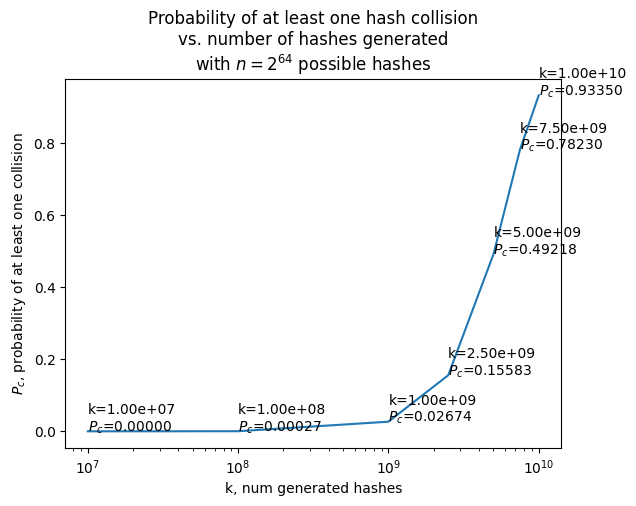

In [20]:
import matplotlib.pyplot as plt

plt.plot(k, P_c)
plt.xscale('log')
plt.title((
    "Probability of at least one hash collision\n"
    "vs. number of hashes generated\n"
    r"with $n=2^{64}$ possible hashes"
))
plt.xlabel("k, num generated hashes")
plt.ylabel("$P_c$, probability of at least one collision")

for k_, P_c_ in zip(k, P_c):
    label = (
        f"k={k_:.2e}\n"
        rf"$P_c$={P_c_:.5f}"
    )
    plt.text(k_, P_c_, label)

print(k)
plt.show()

So it looks like the probability of collision starts becoming significant when we have around 1 billion or more generated hashes. At 5 billion, the probability of collision is very close to 50%.